<a href="https://colab.research.google.com/github/DieterPlessers/materials_informatics_competition/blob/main/notebooks/Challenges_Submission_DP_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Active Learning Agents for Soft Material Phase Mapping**

## **Challenge Notebook**

*Tyler Martin, Peter Beaucage, Shijing Sun, Gilad Kusne*

Spring 2024 Materials Research Society Meeting

Tutorial MT00 - MLMR Competition

Monday April 22, 202



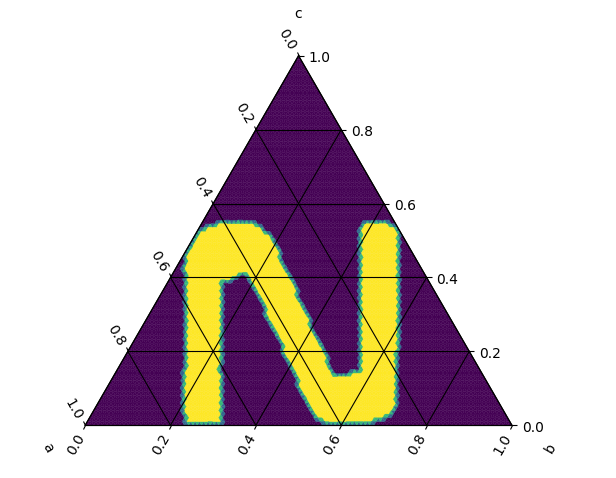

**Goal**
Develop an A.I. agent that most effectively accomplishes a series of phase mapping tasks.

**Details**: This notebook contains three challenges that your agent will be tested against. Each challenge is designed to test a real aspect of building a decision engine for autonomous experiments.

Qualitatively will be scored on the following points:
- How quickly your agent reduces the perimeter score for each challenge
- How much your agent reduces the perimeter score overall for each challenge
- Novelty of your alorithm

**This Competition will end on 5pm EDT Monday, May 6th, 2024.**

**Submitting Results**: Please email the following to tyler.martin@nist.gov with the subject line: MLMR Competition Submission.
1. A copy of this notebook, with you agent coded into it
2. One `.csv` file for each challenge you complete
3. One `.nc` file for each challenge you complete
4. A short description of your agent, written in the "Agent Description" section of this notebook. See that section for more details.

**Rules**
1. You may not modify the initial measurement compositions we provide
2. You may not modify the random number seed
3. You cannot 'hard code' any behavior. We will verify that your algorithm works on similar challenges with varying random number seeds.
4. Please comment your code.
5. You may `pip install` other libraries
6. You are allowed to increase the number of steps that your agent samples for
7. You may download this notebook and run it locally, but (a) we will not provide support for this and (b) we must be able to test your agent in colab during evaluation.
8. Each person or group can submit up to three agents for evaulation

# Setup

**This may take several minutes to complete so please run ASAP**

Please run this collapsed cell by clicking in the box to the left of *8 cells hidden*. This will `pip install` and `import` all necessary dependencies for this tutorial. There is not need to expand this cell block, but you can if you're interested in looking under the hood



If you've never used Google Colab before, [this FAQ](https://research.google.com/colaboratory/faq.html) may be useful to skim. It's very similar (and based off of) Jupyter, but divergent in several ways.

**Warning!**

If you disconnect for too long, you'll have to rerun this cell. Any text you type into this notebooks should always be saved, but variables in memory and files can dissappear when you disconnect.

You're free to download this notebook and run it locally if you're inclined, but we will provide no support for this




In [ ]:
!git clone https://github.com/martintb/active_learning_tutorial.git

Cloning into 'active_learning_tutorial'...
remote: Enumerating objects: 370, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 370 (delta 63), reused 62 (delta 30), pack-reused 269
Receiving objects: 100% (370/370), 2.76 MiB | 19.47 MiB/s, done.
Resolving deltas: 100% (228/228), done.


In [ ]:
%cd /content/active_learning_tutorial

/content/active_learning_tutorial


In [ ]:
!pip install -e .

Obtaining file:///content/active_learning_tutorial
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.4/535.4 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 14.1 MB/s eta 0:00:00
  Building editable for tutlib (pyproject.toml) ... done
  Created wheel for tutlib: filename=tutlib-0.0.1-0.editable-py3-none-any.whl size=2551 sha256=3442646ac670c9b27f73e20d377aedfc36af9faf428c8b057ef92f9e23d

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import gpflow

import sklearn.cluster
from sklearn.metrics import pairwise
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern

import plotly.express as px
import plotly.graph_objects as go

import xarray as xr
xr.set_options(display_expand_data=False)

In [ ]:
from tutlib import *
from tutlib.instruments import starting_composition_list
from tutlib.instruments.tutorial import get_virtual_instrument as get_virtual_instrument0
from tutlib.instruments.challenge1 import get_virtual_instrument as get_virtual_instrument1
from tutlib.instruments.challenge2 import get_virtual_instrument as get_virtual_instrument2
from tutlib.instruments.challenge3 import get_virtual_instrument as get_virtual_instrument3

In [ ]:
%cd /content/active_learning_tutorial/

/content/active_learning_tutorial


In [ ]:
np.random.seed(240425)

# Configure Agent

The methods defined in the tutorial notebook have been blanked out here. Feel free to copy those methods as a starting point or try something new! See the "inspiration" section at the end of the notebook if you're out of ideas.



## Label

In [ ]:
def label(dataset: xr.Dataset, num_phases: int) -> xr.Dataset:
    '''
    Contract: Make the following changes to the 'dataset' variable
        - Set variables "labels" with dimension "sample"
        - Set attribute "n_phases"
    '''
    # create spectral clustering object
    clf = sklearn.cluster.SpectralClustering(
        n_clusters=num_phases,
        affinity='laplacian',
        gamma=8e-4,
        )

    # apply clustering algorithm to sas data
    clf.fit(dataset['sas'])

    #store results in the dataset
    dataset['labels'] = ('sample', clf.labels_)
    dataset['labels'].attrs['description'] = 'ML-defined label for each measurement'
    dataset.attrs['n_phases'] = num_phases
    return dataset

## Extrapolate

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def extrapolate(dataset: xr.Dataset) -> xr.Dataset:
    '''
    Extrapolate the data labels over a composition space
    Contract: Make the following changes to the 'dataset' variable
    - Set variables "acquisition" and "labels_grid" with dimension "grid"
    '''
    # create and train a KNN classifier
    clf = KNeighborsClassifier(n_neighbors=5,
                              weights='distance',
                              )

    clf.fit(
        X=dataset[['c','a','b']].to_array().transpose('sample',...),
        y=dataset['labels']
    )

    # gather 'grid' of composition points to evaluate trained GP on
    Xp = dataset[['c_grid','a_grid','b_grid']].to_array().transpose('grid',...)

    # evaluate trained GP on grid
    labels_grid = clf.predict(Xp)

    # calculate entropy of prediction
    label_prob = clf.predict_proba(Xp)

    #store results in the dataset
    dataset['labels_grid_prob'] = (('grid','phase'), label_prob)
    dataset['labels_grid_prob'].attrs['description'] = 'Probability of each label at every composition of the grid'

    dataset['labels_grid'] = ('grid', labels_grid)
    dataset['labels_grid'].attrs['description'] = 'Most likely label at every composition of the grid'

    return dataset

## Acquire

In [ ]:
def choose_next_acquisition(dataset: xr.Dataset) -> xr.Dataset:
    """
    Use information from previous methods to decide next optimal measurement
    Contract: Make the following changes to the 'dataset' variable
      - add a dictionary named 'next_sample' to the attributes of dataset
      - next sample should be like {'a':0.1, 'b':0.2, 'c':0.7}
    """
    # calculate the acquisition surface from the label probability of the GP.
    # In this case, we'll calculate the entropy of the mean function.
    yp = dataset['labels_grid_prob']
    acquisition = (-np.log(yp)*yp).sum('phase')

    # get index max value of acquisition surface and cast to integer
    next_sample_index = int(acquisition.argmax())

    # get composition associated with selection
    next_sample_comp = dataset[['c_grid', 'a_grid', 'b_grid']].isel(grid = next_sample_index)

    next_sample_comp_dict = {k.replace('_grid',''):v for k,v in next_sample_comp.to_pandas().to_dict().items()}
    dataset.attrs['next_sample'] = next_sample_comp_dict

    dataset["acquisition"] = acquisition #don't need to specify dimension because it's already a DataArray
    dataset["acquisition"].attrs['description'] = "acquisition/decision surface"

    return dataset

# Agent Description

Please write a description of your agent, including any specific implementation details or reasoning that went into the agent desin. This writeup will be essential for our understanding of your submission. We expect something between several sentences to a couple of paragraphs at most.

As the original code was already giving good results - also on the challenges - we used this code as a starting point and as baseline for assessing our modifications.

**1) Label:** We conducted various experiments using different clustering methods such as [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [KMedioids](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html) and [Gaussian mixture models](https://scikit-learn.org/stable/modules/mixture.html). Despite parameter tuning, they consistently underperformed compared to the baseline [spectral clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) method. Thus, we retained spectral clustering and explored alternative affinities, where the Laplacian gave the best results. Regarding the gamma parameter, a slight improvement was observed when setting it to $8*10^{-4}$ alongside our adapted extrapolate function (see below).

Simultaneously, we investigated curve smoothing as preprocessing technique. We experimented with moving average methods and [Savitzky-Golay filters](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html). Although they smoothed the curves, they failed to yield significant performance improvements. Moreover, they slowed down the code, particularly when [implemented](https://dsp.stackexchange.com/a/64313) for non-uniformly spaced q-values. Thus, we left them out and stayed with spectral clustering with optimized gamma.


**2) Extrapolate:**  In the other submitted notebook we explored a GaussianProcessClassifier with a [RationalQuadratic](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html) kernel. In the present notebook, we use a [KNN classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) with surprisingly good results — especially for the phase map with 4 phases. Varying the number of nearest neighbors between 5 and 10 only had a slight impact on results, but **5 nearest neighbors** consistently performed well. Weighing points by the inverse of their distance, i.e. closer neighbors of a point will have a greater influence than neighbors which are further away, delivered significantly better results than the default option of uniform weights. Interestingly, this approach offers the benefit of faster code execution compared to using a GaussianProcessClassifier. It is worth mentioning that we also tested a [Radius Neighbors classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html), which yielded worse results across all tested radii (with closer values to 1 performing slightly better).

**3) Acquire:** Entropy seemed a sensible choice that gave consistent good results combined with the other functions, so we retained this function.


# Challenge 1 - Noise

A common issue in developing active learning schemes for material science problems is that real measurement data can have significant noise. In order to be effective, your agent must be robust to measurement noise, so this first challenge is designed test this.

In [ ]:
instrument1 = get_virtual_instrument1()
instrument1._plot_ground_truth_data()

FigureWidget({
    'data': [{'a': array([ 1.        ,  0.98989899,  0.97979798, ..., -0.01      , -0.01      ,
                          -0.01      ]),
              'b': array([0.        , 0.        , 0.        , ..., 0.98994975, 0.99497487,
                          1.        ]),
              'c': array([0.        , 0.01010101, 0.02020202, ..., 0.01005025, 0.00502513,
                          0.        ]),
              'cliponaxis': False,
              'marker': {'size': 12, 'symbol': 'triangle-up'},
              'mode': 'markers',
              'type': 'scatterternary',
              'uid': '1844371e-2adb-4f31-84a5-53ec089a7108'},
             {'a': array([ 0.3030303 ,  0.29292929,  0.28282828, ..., -0.01      , -0.01      ,
                          -0.01      ]),
              'b': array([0.19191919, 0.19191919, 0.19191919, ..., 0.80904523, 0.81407035,
                          0.81909548]),
              'c': array([0.50505051, 0.51515152, 0.52525253, ..., 0.19095477, 0.1859

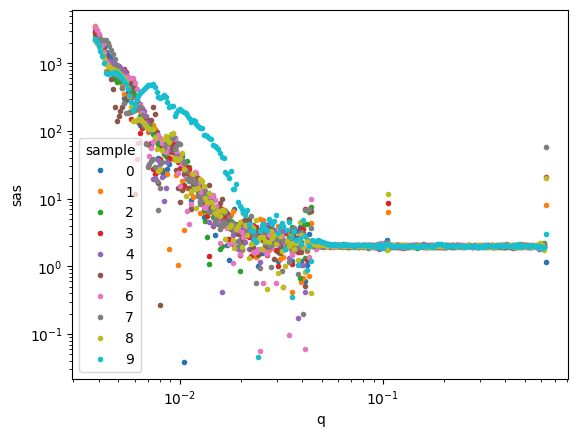

In [ ]:
input_dataset1 = instrument1.measure_multiple(starting_composition_list)
input_dataset1.sas.plot.line(x='q', xscale='log', yscale='log', marker='.', ls='none');

In [ ]:
results = actively_learn(
    niter = 100,
    num_phases=2,
    input_dataset=input_dataset1,
    label=label,
    extrapolate=extrapolate,
    choose_next_acquisition=choose_next_acquisition,
    instrument=instrument1,
    plot=True,
    plot_every=5,
    plot_skip_phases=['D'],
)

100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


When you're happy with the results, use the following cell to save the active learning run. You can then download the netcdf and csv files from the file browser at left.

**Warning!**

If the notebook disconnects before you download the results, you *will* lose access to them.

In [ ]:
results.attrs['next_sample'] = str(results.attrs['next_sample'])
results.to_netcdf('../challenge1.nc')

df = results[['score_mean','score_std']].to_array('metric').stack(stack=['metric','phase']).to_pandas()
df.to_csv('../challenge1.csv')

# Challenge 2 - Multiple Phases

Real soft materials often have multiple strucrual phases, as is the case with the study that we're borrowing these phase boundaries from. In this challenge, we test how well your agent handles a four phase problem.


In [ ]:
instrument2 = get_virtual_instrument2()
instrument2._plot_ground_truth_data()

FigureWidget({
    'data': [{'a': array([ 0.84848485,  0.83838384,  0.82828283, ..., -0.01      , -0.01      ,
                          -0.01      ]),
              'b': array([0.        , 0.        , 0.        , ..., 0.98994975, 0.99497487,
                          1.        ]),
              'c': array([0.15151515, 0.16161616, 0.17171717, ..., 0.01005025, 0.00502513,
                          0.        ]),
              'cliponaxis': False,
              'marker': {'size': 12, 'symbol': 'triangle-up'},
              'mode': 'markers',
              'type': 'scatterternary',
              'uid': 'efe90f8e-d105-42ee-a9e2-9a273ebc0739'},
             {'a': array([0.66666667, 0.65656566, 0.66666667, ..., 0.38383838, 0.37373737,
                          0.36363636]),
              'b': array([0.18181818, 0.18181818, 0.19191919, ..., 0.52525253, 0.52525253,
                          0.53535354]),
              'c': array([0.15151515, 0.16161616, 0.14141414, ..., 0.09090909, 0.1010101 ,


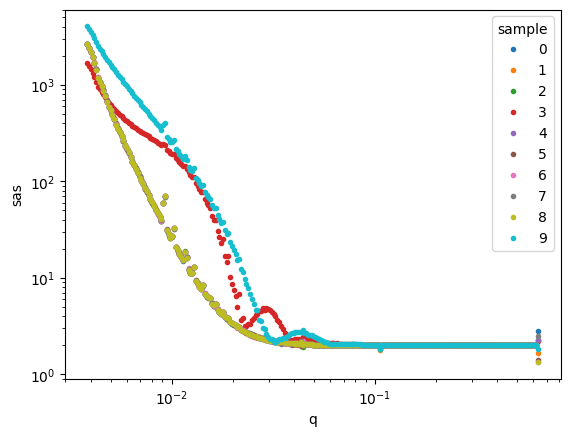

In [ ]:
input_dataset2 = instrument2.measure_multiple(starting_composition_list)
input_dataset2.sas.plot.line(x='q', xscale='log', yscale='log', marker='.', ls='none')

In [ ]:
results = actively_learn(
    niter = 500,
    num_phases=4,
    input_dataset=input_dataset2,
    label=label,
    extrapolate=extrapolate,
    choose_next_acquisition=choose_next_acquisition,
    instrument=instrument2,
    plot=True,
    plot_every=5,
    plot_skip_phases=['D'],
)

100%|██████████| 500/500 [07:39<00:00,  1.09it/s]


When you're happy with the results, use the following cell to save the active learning run. You can then download the netcdf and csv files from the file browser at left.

**Warning!**

If the notebook disconnects before you download the results, you *will* lose access to them.

In [ ]:
results.attrs['next_sample'] = str(results.attrs['next_sample'])
results.to_netcdf('../challenge2.nc')

df = results[['score_mean','score_std']].to_array('metric').stack(stack=['metric','phase']).to_pandas()
df.to_csv('../challenge2.csv')

# Challenge 3 - Intra-Phase Structural Variation

Soft materials can have structrual variation within "phases". For example, a spherical phase can display variation sphere radius as a function of sample composition. Here we test whether your A.I. is robust to this non-ideality.

In [ ]:
instrument3 = get_virtual_instrument3()
instrument3._plot_ground_truth_data()

FigureWidget({
    'data': [{'a': array([ 1.        ,  0.98989899,  0.97979798, ..., -0.01      , -0.01      ,
                          -0.01      ]),
              'b': array([0.        , 0.        , 0.        , ..., 0.98994975, 0.99497487,
                          1.        ]),
              'c': array([0.        , 0.01010101, 0.02020202, ..., 0.01005025, 0.00502513,
                          0.        ]),
              'cliponaxis': False,
              'marker': {'size': 12, 'symbol': 'triangle-up'},
              'mode': 'markers',
              'type': 'scatterternary',
              'uid': 'e5a0bbec-c169-4161-bc1d-47f210b4fb5d'},
             {'a': array([ 0.3030303 ,  0.29292929,  0.28282828, ..., -0.01      , -0.01      ,
                          -0.01      ]),
              'b': array([0.19191919, 0.19191919, 0.19191919, ..., 0.80904523, 0.81407035,
                          0.81909548]),
              'c': array([0.50505051, 0.51515152, 0.52525253, ..., 0.19095477, 0.1859

We're re-using the phase boundaries from the first challenge but now, if we sample across the phase region, we see that the scattering is changing continuously.

FigureWidget({
    'data': [{'a': array([0.125     , 0.11111111, 0.09722222, 0.08333333, 0.06944444, 0.05555556,
                          0.04166667, 0.02777778, 0.01388889, 0.        ]),
              'b': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444, 0.55555556,
                          0.66666667, 0.77777778, 0.88888889, 1.        ]),
              'c': array([0.375     , 0.33333333, 0.29166667, 0.25      , 0.20833333, 0.16666667,
                          0.125     , 0.08333333, 0.04166667, 0.        ]),
              'cliponaxis': False,
              'marker': {'size': 12, 'symbol': 'triangle-up'},
              'mode': 'markers',
              'type': 'scatterternary',
              'uid': '0c8fae0b-a38a-49cd-9200-d210e6cd8b97'}],
    'layout': {'showlegend': False,
               'template': '...',
               'ternary': {'aaxis': {'linewidth': 2, 'min': 0.01, 'ticks': 'outside', 'title': {'text': 'c'}},
                           'baxis': {'linewidth'

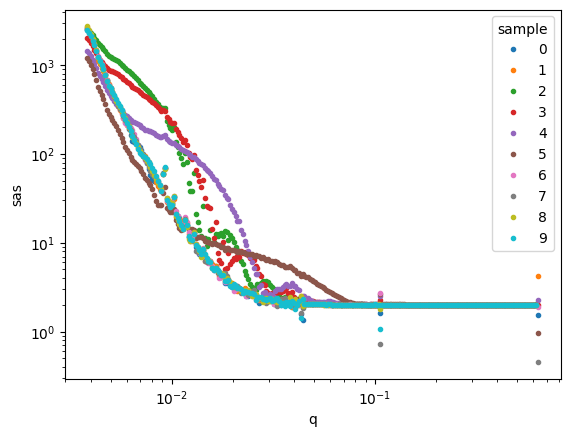

In [ ]:
composition_list = []
for c in np.linspace(0,1,10):
  composition_list.append({'b':0.75*(1.0-c)/2,'c':0.25*(1.0-c)/2,'a':c})

test_dataset = instrument3.measure_multiple(composition_list)
test_dataset.sas.plot.line(x='q', xscale='log', yscale='log', marker='.', ls='none')
plot_ternary(test_dataset,components=['c','a','b'],include_surface=False)

You still need to start your active learning run with the same initial points as the others.

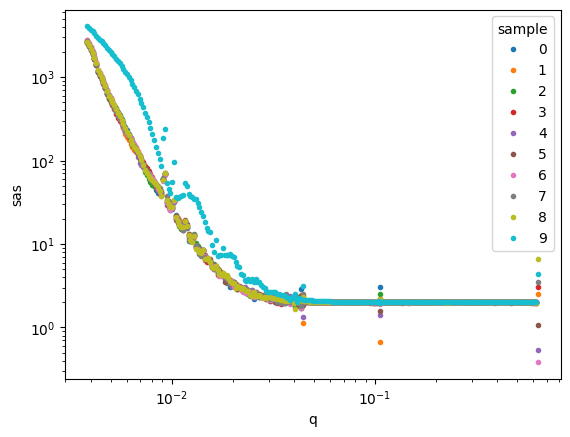

In [ ]:
input_dataset3 = instrument3.measure_multiple(starting_composition_list)
input_dataset3.sas.plot.line(x='q', xscale='log', yscale='log', marker='.', ls='none')

In [ ]:
results = actively_learn(
    niter = 150,
    num_phases=2,
    input_dataset=input_dataset3,
    label=label,
    extrapolate=extrapolate,
    choose_next_acquisition=choose_next_acquisition,
    instrument=instrument3,
    plot=True,
    plot_every=5,
    plot_skip_phases=['D'],
)

100%|██████████| 150/150 [01:29<00:00,  1.67it/s]


When you're happy with the results, use the following cell to save the active learning run. You can then download the netcdf and csv files from the file browser at left.

In [ ]:
results.attrs['next_sample'] = str(results.attrs['next_sample'])
results.to_netcdf('../challenge3.nc')

df = results[['score_mean','score_std']].to_array('metric').stack(stack=['metric','phase']).to_pandas()
df.to_csv('../challenge3.csv')

# Thoughts and Inspiration

Below we share some thoughts, ideas, and inspiration for how you might improve your agent. Not all of these ideas are well tested so use at your own risk. :)



##Labeler
- Improve data preprocessing via smoothing
- Try training a classifier rather than using a clustering routine
- Modify the similarity type (Laplacian) or parameters
- Change the clustering routine

## Extrapolation

 - Maybe something other than a GP might work better?
    - level set methods?
 - Try tuning the GP kernel parameters
 - Try a different GP kernel!

## Acquisition

- Try operating on the gradient of the entropy (or another parameter)
- Try adding an exclusion zone so the acquisition function doesn't place points too close to one another
- Try implementing a different acquisition function (upper confidence bound, Thompson Sampling, etc)